Descargando datos desde BigQuery...
Limpiando datos...
Filas eliminadas: 454379
Entrenando Regresión Logística Offline...

RESULTADOS DEL MODELO OFFLINE
ROC AUC Score: 0.8271
----------------------------------------
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83   1815536
           1       0.13      0.78      0.22     93589

    accuracy                           0.73   1909125
   macro avg       0.56      0.75      0.53   1909125
weighted avg       0.94      0.73      0.80   1909125

Generando gráficas...


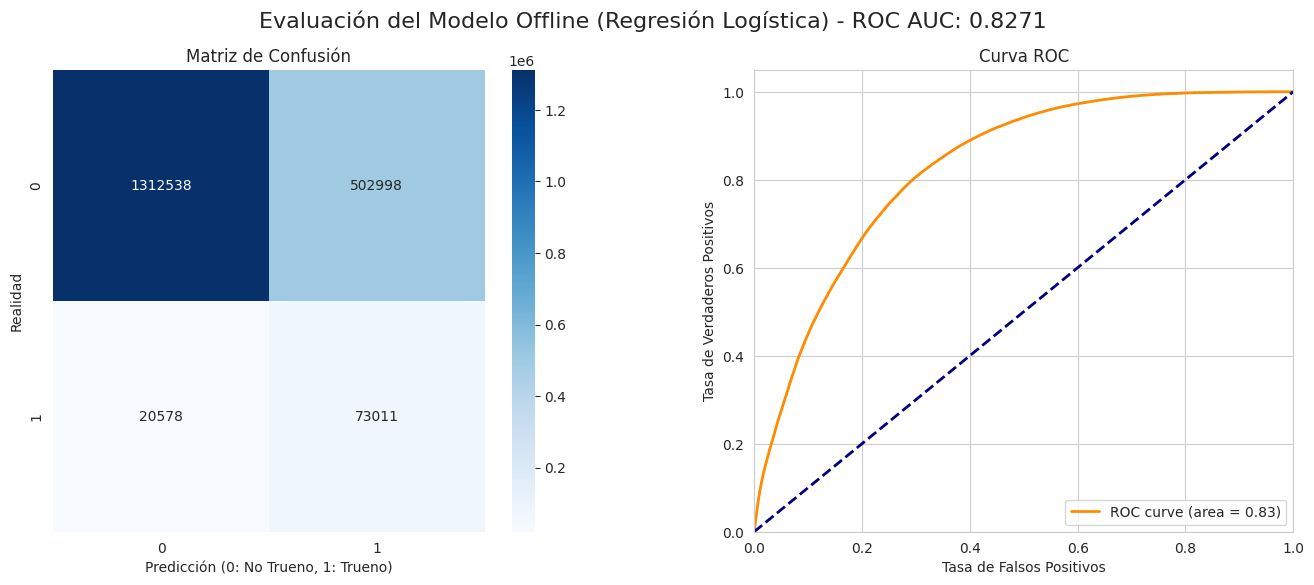

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

QUERY = """
    SELECT 
        year, mo, da, 
        temp, dewp, slp, stp, wdsp, mxpsd, max, min, prcp, sndp, thunder
    FROM `bigquery-public-data.noaa_gsod.gsod*`
    WHERE _TABLE_SUFFIX BETWEEN '2015' AND '2025'
    LIMIT 10000000
"""

print("Descargando datos desde BigQuery...")
client = bigquery.Client(project="cc-proyect")
df = client.query(QUERY).to_dataframe()

print("Limpiando datos...")

df['target'] = df['thunder'].astype(int)

sentinels = {
    'temp': 9999.9,
    'dewp': 9999.9,
    'slp': 9999.9,
    'wdsp': 999.9,
    'sndp': 999.9,
    'prcp': 99.99
}

features = ['temp', 'dewp', 'slp', 'wdsp', 'prcp','sndp']

for col, sentinel in sentinels.items():
    if col in df.columns:
        df[col] = df[col].replace(sentinel, np.nan)
        
zero_fill_cols = ['sndp', 'prcp']
for col in zero_fill_cols:
    df[col] = df[col].fillna(0)

cols_to_drop_if_empty = ['temp', 'dewp','wdsp', 'prcp']

initial_rows = len(df)
df.dropna(subset=cols_to_drop_if_empty, inplace=True)
dropped_rows = initial_rows - len(df)
print(f"Filas eliminadas: {dropped_rows}")

X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = make_pipeline(
    SimpleImputer(strategy='mean'), 
    StandardScaler(),
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
)

print("Entrenando Regresión Logística Offline...")
pipeline.fit(X_train, y_train)

print("\n" + "="*40)
print("RESULTADOS DEL MODELO OFFLINE")
print("="*40)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)

print(f"ROC AUC Score: {roc_auc:.4f}")
print("-" * 40)
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("Generando gráficas...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 
plt.subplots_adjust(wspace=0.3)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión')
axes[0].set_xlabel('Predicción (0: No Trueno, 1: Trueno)')
axes[0].set_ylabel('Realidad')

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].set_title('Curva ROC')
axes[1].legend(loc="lower right")

plt.suptitle(f"Evaluación del Modelo Offline (Regresión Logística) - ROC AUC: {roc_auc:.4f}", fontsize=16)
plt.show()